# Setup

In [3]:
import numpy as np
import pandas as pd
from PIL import Image
import time
import math
import wandb
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from common import transfer_functions, utils

In [5]:
def Epoch(img, s, w_i_h, w_h_o, b_i_h, b_h_o):
    # Forward propagation input -> hidden
    h_pre = b_i_h + w_i_h @ img
    h = transfer_functions.sigmoid(h_pre)
    # Forward propagation hidden -> output
    o_pre = b_h_o + w_h_o @ h
    o = transfer_functions.sigmoid(o_pre)

    # Backpropagation output -> hidden (cost function ddverivative)
    delta_o = o - s  # cross_entropy(s, o) * o
    w_h_o += -learn_rate * delta_o @ np.transpose(h)
    b_h_o += -learn_rate * delta_o

    # Backpropagation hidden -> input (activation function derivative)
    delta_h = np.transpose(w_h_o) @ delta_o * (h * (1 - h))
    w_i_h += -learn_rate * delta_h @ np.transpose(img)
    b_i_h += -learn_rate * delta_h
    return w_i_h, w_h_o, b_i_h, b_h_o

In [6]:
def evaluate(img, s, w_i_h, w_h_o, b_i_h, b_h_o):

    # Forward propagation input -> hidden
    h_pre = b_i_h + w_i_h @ img
    h = transfer_functions.sigmoid(h_pre)
    # Forward propagation hidden -> output
    o_pre = b_h_o + w_h_o @ h
    o = transfer_functions.sigmoid(o_pre)

    return o

# Train Model

In [ ]:
dataset = "Basic11"
Model_name = "StartingTest"

mazes, solves = utils.load_data(f"datasets/Mazes/{dataset}.pickle")

input_layer_size = 121
hidden_layer_size = 100
output_layer_size = 121

learn_rate = 1
epochs = 40

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="MazeSolver",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": learn_rate,
    "hidden_layer_sizes": [100],
    "dataset": dataset,
    "activation": "Sigmoid",
    "epochs": epochs,
    },
)


# weights = w, biases = b, input = i, hidden = h, output = o
# w_i_h = weights input to hidden

# Initialize layers
w_i_h = np.random.uniform(-0.5, 0.5, (hidden_layer_size, input_layer_size))
w_h_o = np.random.uniform(-0.5, 0.5, (output_layer_size, hidden_layer_size))
b_i_h = np.zeros((hidden_layer_size, 1))
b_h_o = np.zeros((output_layer_size, 1))

'''
TODO Implement Batches

Load data into memory based off of batch number, back propogate in batches
Currently we are using batch size=1 or schotastic training. while also loading all of the data into memory
this is a less direct training approach and when moving to larger datasets will destroy our memory.

TODO convert dataset to a batchable type
'''
test_partition = 5000

for epocho in range(epochs):
    for index in range(len(mazes) - test_partition):
        img, s = mazes[index], solves[index]
        img.shape += (1,)
        s.shape += (1,)
        w_i_h, w_h_o, b_i_h, b_h_o = Epoch(img, s, w_i_h, w_h_o, b_i_h, b_h_o)
    
    factor = 10
    average_score = []
    loss = []

    for index in range(-1, -test_partition, -1):
        img, s = mazes[index], solves[index]
        img.shape += (1,)
        s.shape += (1,)
        s_pred = evaluate(img, s, w_i_h, w_h_o, b_i_h, b_h_o)

        average = 1 - abs(s - s_pred).mean()
        score = math.exp((average-1)*factor)*average
        average_score.append(score)
        loss.append(log_loss(s, s_pred))

    mean_acc = np.mean(average_score)*100
    highest_acc = np.amax(average_score) * 100
    lowest_acc = np.amin(average_score) * 100
    mean_loss = np.mean(loss)
    wandb.log({
        "Accuracy": mean_acc,
        "Loss": mean_loss 
        })


    # Show accuracy for this epoch
    print(f"Epoch #{epocho} Mean Acc: {round(mean_acc, 3)}% Highest Acc: {round(highest_acc, 3)}% Lowest Acc: {round(lowest_acc, 3)}%")
    #print(f"Index High: {average_score.index(np.amax(average_score))} Index Low: {average_score.index(np.amin(average_score))}")

wandb.finish()
utils.store_model(f"models/Mazes/{Model_name}.pickle", w_i_h, w_h_o, b_i_h, b_h_o)

# Load Model

In [97]:
w_i_h, w_h_o, b_i_h, b_h_o = utils.load_model("models/11x11MazeModel.pickle", 3)

# Model Testing

73.27809652150397


<Figure size 640x480 with 0 Axes>

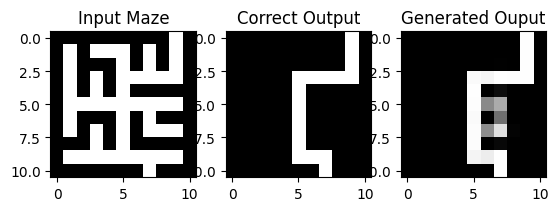

In [144]:
# Last Thousand images are not used in training
test_index = 3456

# Extract Maze
maze = mazes[test_index]
solve = solves[test_index]
maze.shape += (1,)
solve.shape += (1,)

# Forward propagation input -> hidden
h_pre = b_i_h + w_i_h @ maze
h = transfer_functions.sigmoid(h_pre)
# Forward propagation hidden -> output
o_pre = b_h_o + w_h_o @ h
o = transfer_functions.sigmoid(o_pre)

# Show Output
reshaped_maze = 255 - maze.reshape(11, 11) * 255
reshaped_solve = solve.reshape(11, 11) * 255
reshaped_o = o.reshape(11, 11) * 255

maze_img = Image.fromarray(reshaped_maze)
solve_img = Image.fromarray(reshaped_solve)
o_img = Image.fromarray(reshaped_o)

# Creat Plot
plt.figure()
f, axarr = plt.subplots(1,3) 

axarr[0].title.set_text("Input Maze")
axarr[0].imshow(maze_img)
axarr[1].title.set_text("Correct Output")
axarr[1].imshow(solve_img)
axarr[2].title.set_text("Generated Ouput")
axarr[2].imshow(o_img)

average = 1 - abs(solve - o).mean()
factor = 10
score = math.exp((average-1)*factor)*average

print(score * 100)


<Figure size 640x480 with 0 Axes>

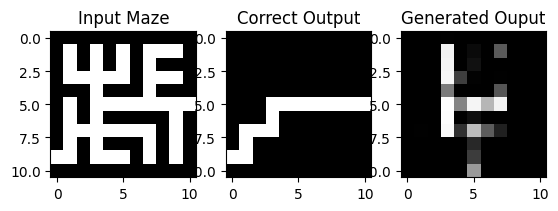

In [147]:

# Last Thousand images are not used in training
test_index = -20

# Extract Maze
maze = mazes[test_index].reshape(11, 11)
solve = solves[test_index].reshape(11, 11)
maze = maze.T
solve = solve.T

maze = maze.flatten()
solve = solve.flatten()

maze.shape += (1,)
solve.shape += (1,)

# Forward propagation input -> hidden
h_pre = b_i_h + w_i_h @ maze
h = transfer_functions.sigmoid(h_pre)
# Forward propagation hidden -> output
o_pre = b_h_o + w_h_o @ h
o = transfer_functions.sigmoid(o_pre)

# Show Output
reshaped_maze = 255 - maze.reshape(11, 11) * 255
reshaped_solve = solve.reshape(11, 11) * 255
reshaped_o = o.reshape(11, 11) * 255

maze_img = Image.fromarray(reshaped_maze)
solve_img = Image.fromarray(reshaped_solve)
o_img = Image.fromarray(reshaped_o)

# Creat Plot
plt.figure()
f, axarr = plt.subplots(1,3) 

axarr[0].title.set_text("Input Maze")
axarr[0].imshow(maze_img)
axarr[1].title.set_text("Correct Output")
axarr[1].imshow(solve_img)
axarr[2].title.set_text("Generated Ouput")
axarr[2].imshow(o_img)

## Removing Duplicates test

In [ ]:


mazes, solves = utils.load_data(f"datasets/Mazes/Basic11.pickle")

mazes_df = pd.DataFrame(mazes)

arr, uniq_cnt = np.unique(mazes, axis=0, return_counts=True)
uniq_arr = arr[uniq_cnt>1]
same_arr = arr[uniq_cnt==1]

print(pd.DataFrame(same_arr).describe())

indicies = np.where((mazes == uniq_arr[1]).all(axis=1))
print(indicies)

reshaped_maze = 255 - mazes[161].reshape(11, 11) * 255
reshaped_solve = 255 - mazes[36897].reshape(11, 11) * 255
#reshaped_o = o.reshape(11, 11) * 255

maze_img = Image.fromarray(reshaped_maze)
solve_img = Image.fromarray(reshaped_solve)
#o_img = Image.fromarray(reshaped_o)

# Creat Plot
plt.figure()
f, axarr = plt.subplots(1,2) 

axarr[0].title.set_text("Input Maze")
axarr[0].imshow(maze_img)
axarr[1].title.set_text("Correct Output")
axarr[1].imshow(solve_img)
#axarr[2].title.set_text("Generated Ouput")
#axarr[2].imshow(o_img)

<Figure size 640x480 with 0 Axes>

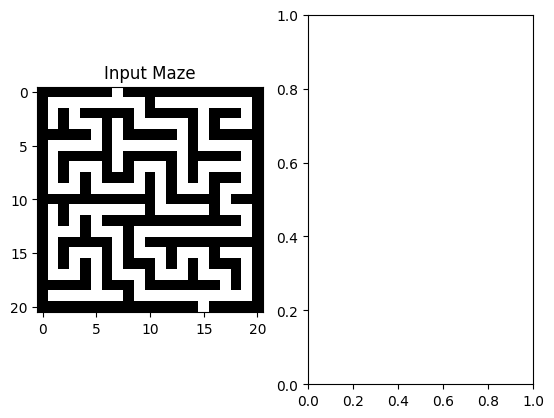

In [4]:
import pickle

with open("datasets/Mazes/NewMazeDataset21.pickle", "rb") as fin:
    mazes = pickle.load(fin)

reshaped_maze = mazes[61].reshape(21, 21) * 255
#reshaped_o = o.reshape(11, 11) * 255

maze_img = Image.fromarray(reshaped_maze)

# Creat Plot
plt.figure()
f, axarr = plt.subplots(1,2) 

axarr[0].title.set_text("Input Maze")
axarr[0].imshow(maze_img)
